# Designing a power divider for wireless communications part 3: Full divider structure

The power divider is a key component in modern wireless communications systems. It is usually subject to key performance metrics such as low insertion loss, minimal crosstalk between output ports, and a small footprint. In addition, low pass or bandpass filters are typically incorporated in order to suppress unwanted harmonics and noise in wireless signals. These filters should have a sharp response, quantified by the roll-off rate (ROR), and a wide stopband. 

In this 3-part notebook series, we will simulate various stages of the design process of a Wilkinson power divider (WPD) created by Moloudian et al in [1]. 
* In [part one](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression1/), we started with a simple low pass filter design and improved its filter response in order to achieve a higher roll-off rate (ROR).
* In [part two](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression2/), we added a harmonic suppression circuit to the low pass filter to improve its stopband performance.
* In part three (this notebook), we will implement the full WPD design and compare its performance to a conventional WPD. 

<center><img src="./img/wpdhs_3_render.png" width=640 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.smatrix as sm
from tidy3d.plugins.dispersion import FastDispersionFitter

td.config.logging_level = "ERROR"

## General Parameters and Mediums

The simulation bandwidth is chosen to be 0.1-16 GHz. We also include the target operating frequency at 1.8 GHz. 

In [2]:
(f_min, f_max) = (0.1e9, 16e9)
f_target = 1.8e9
bandwidth = td.FreqRange.from_freq_interval(f_min, f_max)
f0 = bandwidth.freq0
freqs = np.unique(np.append(f_target, bandwidth.freqs(num_points=601)))

The substrate is FR4 and the metallic traces are copper. We assume both materials have constant non-zero loss across the bandwidth: loss tangent of 0.022 for FR4 and conductivity of 6E7 S/m (i.e. 60 S/um) for copper. 

In [3]:
# med_FR4 = td.Medium(permittivity=4.4)
med_FR4 = FastDispersionFitter.constant_loss_tangent_model(4.4, 0.022, (f_min, f_max))
med_Cu = td.LossyMetalMedium(conductivity=60, frequency_range=(f_min, f_max))

Output()

## Building the Simulation

The full WPD shape is shown in Figure 7(a) of the reference paper and reproduced below. Both arms of the WPD uses the low-pass filter with harmonic suppression presented in the [second notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression2/) in this series. Please refer to the previous notebooks for more detail on the individual structures. 

<center><img src="./img/wpdhs_3_schematic.png" width=480 /></center>

### Structure

All dimensions are taken from [1] where available. Some measurements for the overall WPD are not mentioned, and are instead estimated visually. 

In [4]:
# Geometry dimensions
mm = 1000  # Conversion mm to micron
H = 0.8 * mm  # Substrate thickness
T = 0.035 * mm  # Metal thickness

# Resonator dimensions
MA, MB, MC, MD = (3.9 * mm, 7.1 * mm, 3.1 * mm, 2.3 * mm)
ME, MF, MG, MH = (0.6 * mm, 0.2 * mm, 1.2 * mm, 0.5 * mm)
MJ, MK, MM, MN = (4.8 * mm, 0.3 * mm, 0.1 * mm, 0.7 * mm)
MP, MQ, MR, MS = (0.1 * mm, 0.7 * mm, 0.4 * mm, 0.3 * mm)

# Suppression structure dimensions
SA, SB, SC, SD = (3 * mm, 11.3 * mm, 4.4 * mm, 6.5 * mm)
SE, SF, SG, SH = (2.7 * mm, 1 * mm, 1.7 * mm, 3.7 * mm)
SK, SL, SM, SN = (0.5 * mm, 1 * mm, 0.5 * mm, 4.6 * mm)
SP, SQ, SR, SS, ST = (0.8 * mm, 1.5 * mm, 2 * mm, 5.9 * mm, 4.6 * mm)

# WPD dimensions
WA, WB = (1.5 * mm, 0.6 * mm)
WC = SK / 2 + SN + SK + WB / 2 - WA / 2
(WD, WE, WF, WG) = (0.35 * mm, 3 * mm, 0.8 * mm, 0.3 * mm)

# Lumped resistor dimensions
LRL, LRW = (WF, WA)

The low-pass resonator geometry is constructed below. 

In [5]:
# Resonator geometry
geom_patch = td.Box.from_bounds(rmin=(-MA / 2, MH / 2 + MK, 0), rmax=(MA / 2, MH / 2 + MK + MB, T))
geom_hole1 = td.Box.from_bounds(
    rmin=(-MH / 2 - MN - MF - ME, MH / 2 + MK + MS, 0),
    rmax=(-MH / 2 - MN - MF, MH / 2 + MK + MS + MG, T),
)
geom_hole2 = geom_hole1.translated(2 * (MF + MN) + MH + ME, 0, 0)
geom_hole3 = td.Cylinder(center=(0, MH / 2 + MD + MQ, T / 2), radius=MR, length=T, axis=2)
geom_hole4 = geom_hole3.translated(0, MQ + 2 * MR, 0)
geom_hole5 = td.Box.from_bounds(
    rmin=(-MA / 2 + 1.5 * MF, MH / 2 + MK + MS + MG + MQ, 0),
    rmax=(-MA / 2 + 1.5 * MF + MM, MH / 2 + MK + MB - MP, T),
)
geom_hole6 = geom_hole5.translated(-2 * geom_hole5.center[0], 0, 0)
geom_hole7 = td.Box.from_bounds(
    rmin=(-MH / 2 - MN, MH / 2 + MK, 0), rmax=(MH / 2 + MN, MH / 2 + MD, T)
)
geom_line1 = td.Box.from_bounds(rmin=(-MH / 2, MH / 2, 0), rmax=(MH / 2, MH / 2 + MD, T))
for hole in [geom_hole1, geom_hole2, geom_hole3, geom_hole4, geom_hole5, geom_hole6, geom_hole7]:
    geom_patch -= hole
geom_resonator_modified = td.GeometryGroup(geometries=[geom_line1, geom_patch])

Next, the harmonic suppression geometry is constructed.

In [6]:
# Side patches
def create_side_patch(x0, y0):
    """create side patch geometry with feed input centered at (x0, y0)"""
    patch_vertices = [x0, y0] + np.array(
        [
            [SK / 2, 0],
            [SK / 2, SP],
            [SA / 2, SP],
            [SA / 2, SP + ST],
            [-SA / 2, SP + ST],
            [-SA / 2, SP],
            [-SK / 2, SP],
            [-SK / 2, 0],
        ]
    )
    patch_geom = td.PolySlab(vertices=patch_vertices, axis=2, slab_bounds=(0, T))
    return patch_geom


geom_patch1 = create_side_patch(-(SB + SA) / 2, SK / 2)
geom_patch2 = geom_patch1.reflected((0, -1, 0)).translated(0, 0.3 * mm, 0)
geom_patch3 = geom_patch1.reflected((1, 0, 0))
geom_patch4 = geom_patch3.reflected((0, -1, 0)).translated(0, 0.3 * mm, 0)

In [7]:
# Bend feedline
half_bfl_vertices = np.array(
    [
        [-SD / 2, SK / 2],
        [-SD / 2, -SR / 2 + SK / 2],
        [-SD / 2 - SM, -SR / 2 + SK / 2],
        [-SD / 2 - SM, (SR + SK) / 2],
        [-SD / 2 - SM - SQ, (SR + SK) / 2],
        [-SD / 2 - SM - SQ, SK / 2],
        [-SB / 2 - SC, SK / 2],
        [-SB / 2 - SC, -SK / 2],
        [-SD / 2 - SM - SQ + SK, -SK / 2],
        [-SD / 2 - SM - SQ + SK, SR / 2 - SK / 2],
        [-SD / 2 - SM - SK, SR / 2 - SK / 2],
        [-SD / 2 - SM - SK, -(SR + SK) / 2],
        [-SD / 2 + SK, -(SR + SK) / 2],
        [-SD / 2 + SK, -SK / 2],
    ]
)
bfl_vertices = np.append(half_bfl_vertices, np.flip(half_bfl_vertices * [-1, 1], axis=0), axis=0)
geom_bend_feedline = td.PolySlab(vertices=bfl_vertices, axis=2, slab_bounds=(0, T))

In [8]:
# Bottom middle resonator
bmres_vertices = np.array(
    [
        [-SK / 2, -SK / 2],
        [-SK / 2, -SK / 2 - SN],
        [-SK / 2 - SF, -SK / 2 - SN],
        [-SK / 2 - SF, -SK / 2 - SN - SK + SH],
        [-SS / 2, -SK / 2 - SN - SK + SH],
        [-SS / 2, -SK / 2 - SN - SK],
        [SS / 2, -SK / 2 - SN - SK],
        [SS / 2, -SK / 2 - SN - SK + SH],
        [SK / 2 + SF, -SK / 2 - SN - SK + SH],
        [SK / 2 + SF, -SK / 2 - SN],
        [SK / 2, -SK / 2 - SN],
        [SK / 2, -SK / 2],
    ]
)
geom_bottom_resonator = td.PolySlab(vertices=bmres_vertices, axis=2, slab_bounds=(0, T))

# Group all harmonic suppression geometry objects
geom_harmonic_suppression = td.GeometryGroup(
    geometries=[
        geom_patch1,
        geom_patch2,
        geom_patch3,
        geom_patch4,
        geom_bend_feedline,
        geom_bottom_resonator,
    ]
)

Then, we create the feed lines for the WPD branches. 

In [9]:
# WPD feedlines (top half only)
half_wpd_in_vertices = [-SB / 2 - SC, WA / 2 + WC] + np.array(
    [
        [0, -SK / 2],
        [0, -SR / 2 + SK / 2],
        [-SM, -SR / 2 + SK / 2],
        [-SM, (SR + SK) / 2],
        [-SM - SQ, (SR + SK) / 2],
        [-SM - SQ, SK / 2],
        [-SM - SQ - WD, SK / 2],
        [-SM - SQ - WD, -WC],
        [-SM - SQ - WD - WE, -WC],
        [-SM - SQ - WD - WE, -WC - WA / 2],
        [-SM - SQ - WD + SK, -WC - WA / 2],
        [-SM - SQ - WD + SK, -SK / 2],
        [-SM - SQ + SK, -SK / 2],
        [-SM - SQ + SK, SR / 2 - SK / 2],
        [-SM - SK, SR / 2 - SK / 2],
        [-SM - SK, -(SR + SK) / 2],
        [SK, -(SR + SK) / 2],
        [SK, -SK / 2],
    ]
)
half_wpd_out_vertices = [SB / 2 + SC + SK, WA / 2 + WC] + np.array(
    [
        [0, SK / 2],
        [0, -SR / 2 + SK / 2],
        [SM, -SR / 2 + SK / 2],
        [SM, -SK / 2],
        [SM, (SR + SK) / 2],
        [SM + SQ, (SR + SK) / 2],
        [SM + SQ, SK / 2],
        [SM + SQ + WE + WF + WG, SK / 2],
        [SM + SQ + WE + WF + WG, SK / 2 - WA],
        [SM + SQ + WF + WG, SK / 2 - WA],
        [SM + SQ + WF + WG, -WC - WA / 2 + LRW / 2],
        [SM + SQ + WG, -WC - WA / 2 + LRW / 2],
        [SM + SQ + WG, -SK / 2],
        [SM + SQ - SK, -SK / 2],
        [SM + SQ - SK, SR / 2 - SK / 2],
        [SM + SK, SR / 2 - SK / 2],
        [SM + SK, -(SR + SK) / 2],
        [-SK, -(SR + SK) / 2],
        [-SK, SK / 2],
    ]
)

geom_wpd_feed_in = td.PolySlab(vertices=half_wpd_in_vertices, axis=2, slab_bounds=(0, T))
geom_wpd_feed_out = td.PolySlab(vertices=half_wpd_out_vertices, axis=2, slab_bounds=(0, T))

Finally, all WPD geometries are consolidated into a single geometry group. 

In [10]:
# Create WPD branches
geom_top_branch = td.GeometryGroup(
    geometries=[
        geom_wpd_feed_in,
        geom_wpd_feed_out,
        geom_harmonic_suppression.translated(0, WC + WA / 2, 0),
        geom_resonator_modified.translated(0, WC + WA / 2, 0),
    ]
)
geom_wpd = td.GeometryGroup(geometries=[geom_top_branch, geom_top_branch.reflected((0, -1, 0))])

The associated simulation structures are defined below. 

In [11]:
# Structures
Lsub, Wsub, _ = geom_wpd.bounding_box.size
Wsub = Wsub * 1.1
x0, y0, _ = geom_wpd.bounding_box.center
str_sub = td.Structure(
    geometry=td.Box(center=(x0, y0, -H / 2), size=(Lsub, Wsub, H)), medium=med_FR4
)
str_gnd = td.Structure(
    geometry=td.Box(center=(x0, y0, -H - T / 2), size=(Lsub, Wsub, T)), medium=med_Cu
)
str_wpd = td.Structure(geometry=geom_wpd, medium=med_Cu)

str_list_wpd = [str_sub, str_gnd, str_wpd]  # Full structure list

### Monitors 

We define an in-plane field monitor for visualization purposes. 

In [12]:
# Field Monitors
mon_1 = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[f_min, f_target, f0, f_max],
    name="field in-plane",
)
mon_list = [mon_1]  # List of monitors

### Lumped Ports and Elements

All three ports of the divider are terminated with $Z_0 = 50$ ohms.

In [13]:
# Lumped port
lp_options = {"size": (0, WA, H), "voltage_axis": 2, "impedance": 50}
LP1 = sm.LumpedPort(center=(x0 - Lsub / 2, 0, -H / 2), name="LP1", **lp_options)
LP2 = sm.LumpedPort(center=(x0 + Lsub / 2, WC + SK / 2, -H / 2), name="LP2", **lp_options)
LP3 = sm.LumpedPort(center=(x0 + Lsub / 2, -WC - SK / 2, -H / 2), name="LP3", **lp_options)
port_list = [LP1, LP2, LP3]  # List of ports

The WPD also has a lumped resistor bridging the two output ports with $R = 2Z_0 = 100$ Ohms.

In [14]:
# Lumped resistor
LR1 = td.LinearLumpedElement(
    center=(x0 + Lsub / 2 - WE - WF / 2, 0, T),
    size=(LRL, LRW, 0),
    name="Resistor",
    voltage_axis=1,
    network=td.RLCNetwork(
        resistance=100.0,
    ),
)

### Grid and Boundary

By default, the simulation boundary is open (PML) on all sides. We add wavelength/4 padding on all sides to ensure the boundaries do not encroach on the near-field. 

In [15]:
# Add padding
padding = td.C_0 / f0 / 2
sim_LX = Lsub + padding
sim_LY = Wsub + padding
sim_LZ = H + padding

We use `LayerRefinementSpec` to automatically refine the grid along corners and edges of the metallic WPD traces. The rest of the grid is automatically created with the minimum grid size determined by the wavelength. 

In [16]:
# Layer refinement on resonator
lr_spec = td.LayerRefinementSpec.from_structures(
    structures=[str_wpd],
    min_steps_along_axis=1,
    corner_refinement=td.GridRefinement(dl=T, num_cells=2),
)

# Define overall grid spec
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f0,
    min_steps_per_wvl=12,
    layer_refinement_specs=[lr_spec],
)

### Simulation and TerminalComponentModeler

We define the `Simulation` and `TerminalComponentModeler` objects below. The latter facilitates a batch port sweep in order to compute the full S-parameter matrix. 

As noted in the [previous notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression2/), the device is highly resonant at certain frequencies. To accurately capture its behavior down to the -70 dB level, we should increase the `run_time` and lower the `shutoff` level. Conversely, if we were only interested down to -40 dB, it would be OK to cut off the simulation at a much earlier point to save on computational cost. 

In [17]:
# Define simulation object
sim = td.Simulation(
    center=(x0, y0, 0),
    size=(sim_LX, sim_LY, sim_LZ),
    structures=str_list_wpd,
    lumped_elements=[LR1],
    grid_spec=grid_spec,
    monitors=mon_list,
    run_time=30e-9,
    shutoff=1e-6,
    plot_length_units="mm",
)

In [18]:
# Define TerminalComponentModeler
tcm = sm.TerminalComponentModeler(
    simulation=sim,
    ports=port_list,
    freqs=freqs,
    verbose=True,
    path_dir="data",
    remove_dc_component=False,
)

### Visualization

Before running the simulation, we check the layout and simulation grid below. 

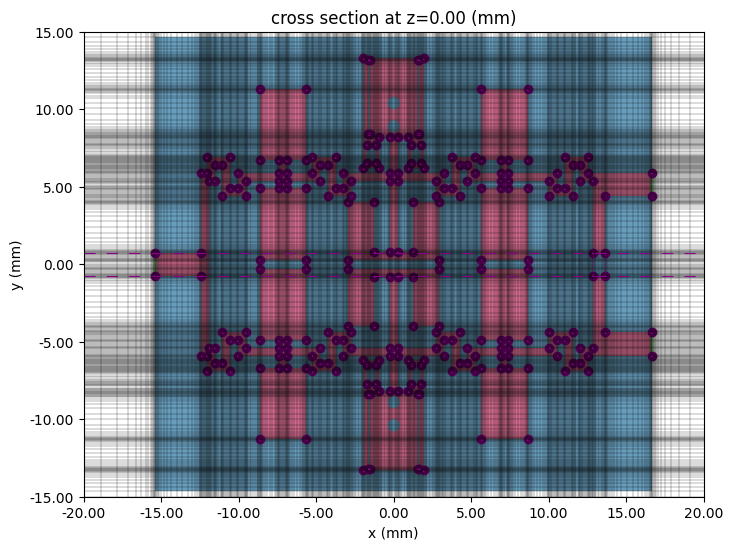

In [19]:
# In-plane
fig, ax = plt.subplots(figsize=(8, 8))
tcm.plot_sim(z=0, ax=ax, monitor_alpha=0)
tcm.simulation.plot_grid(z=0, ax=ax, hlim=(-20 * mm, 20 * mm), vlim=(-15 * mm, 15 * mm))
plt.show()

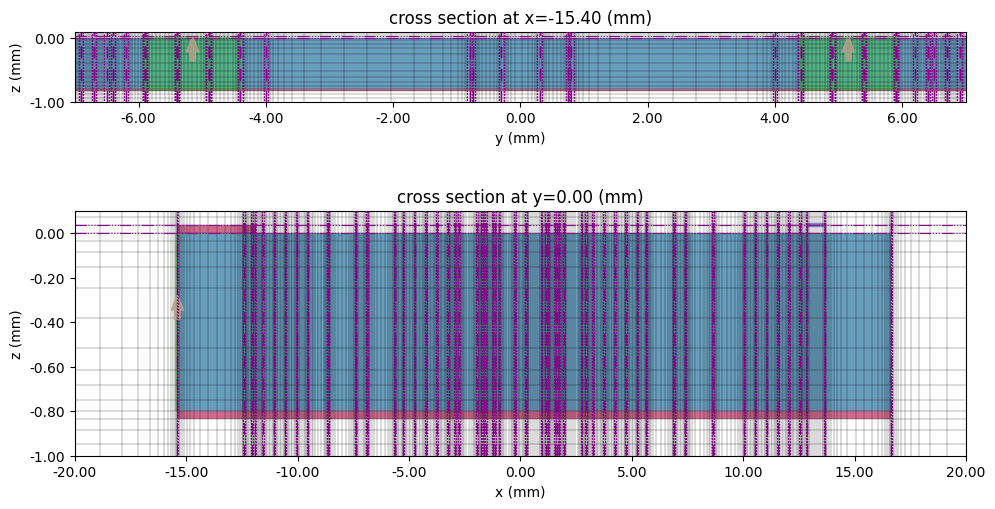

In [20]:
# Cross section
fig, ax = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)
tcm.plot_sim(x=x0 + Lsub / 2, ax=ax[0], monitor_alpha=0)
tcm.simulation.plot_grid(
    x=x0 - Lsub / 2, ax=ax[0], hlim=(-7 * mm, 7 * mm), vlim=(-1 * mm, 0.1 * mm)
)
tcm.plot_sim(y=0, ax=ax[1], monitor_alpha=0)
tcm.simulation.plot_grid(y=0, ax=ax[1], hlim=(-20 * mm, 20 * mm), vlim=(-1 * mm, 0.1 * mm))
ax[1].set_aspect(10)
plt.show()

### Running the Simulation

In [21]:
_ = tcm.batch.estimate_cost()

11:47:30 EDT Maximum FlexCredit cost: 19.141 for the whole batch.

In [22]:
smat = tcm.run()

Output()

             Started working on Batch containing 3 tasks.

11:47:34 EDT Maximum FlexCredit cost: 19.141 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

11:47:35 EDT Batch complete.

Output()

In [23]:
_ = tcm.batch.real_cost()

11:48:56 EDT Total billed flex credit cost: 15.313.

### Results

#### Field Profile

All monitor data can be referenced using the `batch_data` attribute of the `TerminalComponentModeler`. We use the `'smatrix_LP1'` key to refer to the data associated with port excitation of `LP1`. 

In [24]:
sim_data = tcm.batch_data["smatrix_LP1"]

The field magnitude profiles at `f=f_target` and `f=f0` (within the stopband) are shown below. 

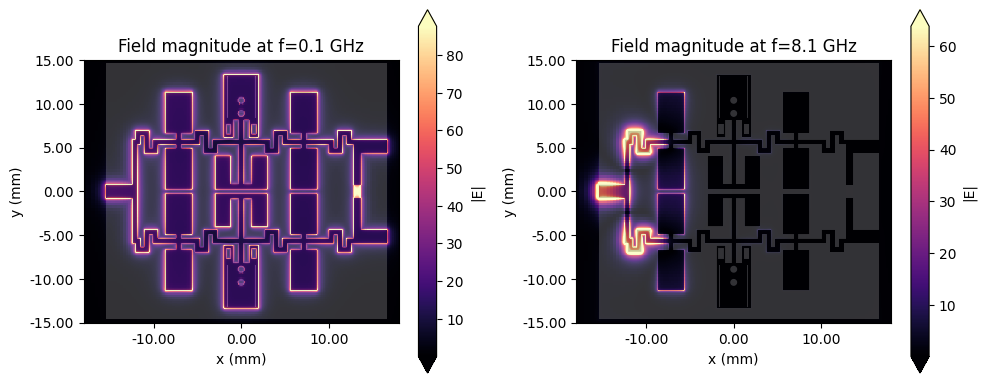

In [25]:
# Field plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
sim_data.plot_field("field in-plane", "E", val="abs", f=f_target, ax=ax[0])
ax[0].set_title(f"Field magnitude at f={f_min / 1e9:.1f} GHz")
sim_data.plot_field("field in-plane", "E", val="abs", f=f0, ax=ax[1])
ax[1].set_title(f"Field magnitude at f={f0 / 1e9:.1f} GHz")
for axis in ax:
    axis.set_xlim(-18 * mm, 18 * mm)
    axis.set_ylim(-15 * mm, 15 * mm)
plt.show()

#### Conventional WPD Model using `scikit-rf` 

As a basis for comparison, we implement a conventional WPD using the `scikit-rf` third-party package. 

In [26]:
# Import necessary packages
import skrf
from skrf.media import MLine

The conventional WPD consists of two output ports, each connected to the input port with a quarter-wavelength line of impedance $Z_c = Z_0\sqrt(2)$. We construct this circuit below. 

In [27]:
# Frequencies and transmission line parameters
freqs_skrf = skrf.Frequency(f_min / 1e9, f_max / 1e9, 601, unit="GHz")
mline = MLine(freqs_skrf, w=0.5e-3, h=0.8e-3, t=35e-6, ep_r=4.4, rho=1.67e-08)
# WPD resistor
R1 = mline.resistor(R=100, name="R1")
# WPD quarter wavelength branches
line1 = mline.line(23.7, unit="mm", z0=50 * np.sqrt(2), name="branch1")
line2 = mline.line(23.7, unit="mm", z0=50 * np.sqrt(2), name="branch2")
# Ports and ground
port1 = skrf.Circuit.Port(frequency=freqs_skrf, name="P1", z0=50)
port2 = skrf.Circuit.Port(frequency=freqs_skrf, name="P2", z0=50)
port3 = skrf.Circuit.Port(frequency=freqs_skrf, name="P3", z0=50)
ground = skrf.Circuit.Ground(frequency=freqs_skrf, name="GND", z0=50)
# Circuit connections
connections = [
    [(port1, 0), (line1, 0), (line2, 0)],
    [(line1, 1), (R1, 0), (port2, 0)],
    [(line2, 1), (R1, 1), (port3, 0)],
]
circuit = skrf.Circuit(connections)
# Network and S-parameters
WPD_skrf = circuit.network
S11dB_skrf = WPD_skrf.s_db[:, 0, 0]
S21dB_skrf = WPD_skrf.s_db[:, 1, 0]
S32dB_skrf = WPD_skrf.s_db[:, 2, 1]

The calculated S-parameters for the conventional WPD will be compared with that of the modified WPD in the next section.

#### S-parameters

The S-parameters of the simulated device can be accessed using the `port_in` and `port_out` coordinates from the full `smat` matrix. Note the use of `np.conjugate()` to convert from the default physics phase convention to the engineering convention. 

In [28]:
S11 = np.conjugate(smat.isel(port_in=0, port_out=0))
S21 = np.conjugate(smat.isel(port_in=0, port_out=1))
S32 = np.conjugate(smat.isel(port_in=1, port_out=2))

Below, we compare the performance of the WPD with its conventional counterpart. The return loss shows greatly improved stopband performance over 2.3 to 14 GHz. 

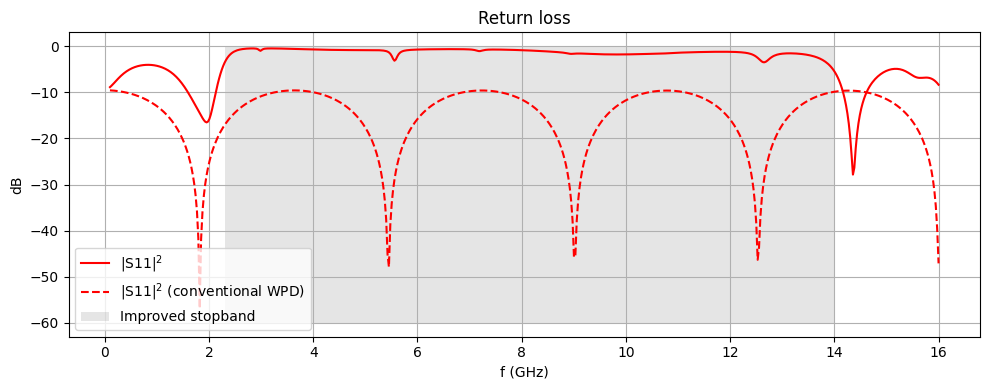

In [29]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S11)), "r", label="|S11|$^2$")
ax.plot(freqs_skrf.f / 1e9, S11dB_skrf, "r--", label="|S11|$^2$ (conventional WPD)")
ax.add_patch(
    plt.Rectangle((2.3, 0), 14 - 2.3, -60, fc="gray", alpha=0.2, label="Improved stopband")
)
ax.legend()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.set_title("Return loss")
ax.grid()
plt.show()

The insertion loss is compared below. At the operating frequency of 1.8 GHz, the proposed WPD has IL = -3.9 dB compared to the ideal -3 dB.

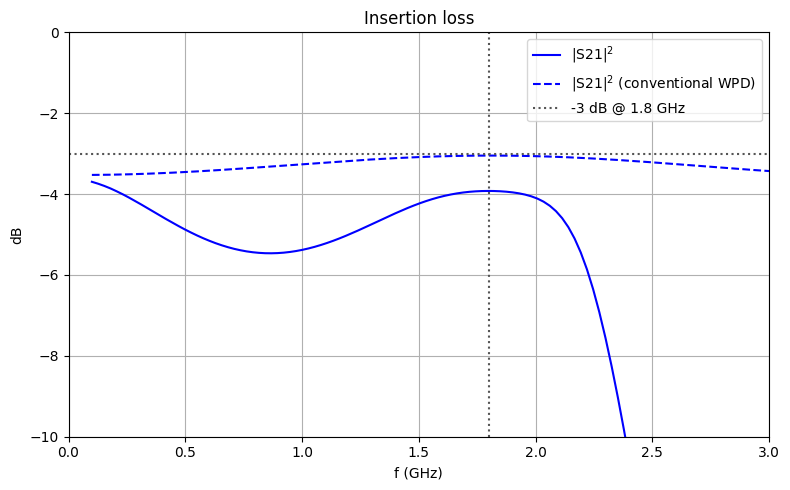

In [30]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S21)), "b", label="|S21|$^2$")
ax.plot(freqs_skrf.f / 1e9, S21dB_skrf, "b--", label="|S21|$^2$ (conventional WPD)")
ax.axline(xy1=(0.1, -3), xy2=(f_max / 1e9, -3), color="#555555", ls=":", label="-3 dB @ 1.8 GHz")
ax.axline(xy1=(1.8, 0), xy2=(1.8, -10), color="#555555", ls=":")
ax.legend()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.set_title("Insertion loss")
ax.set_xlim(0, 3)
ax.set_ylim(-10, 0)
ax.grid()
plt.show()

Like the conventional counterpart, the proposed WPD maintains very good isolation (better than -20 dB) between the output ports. 

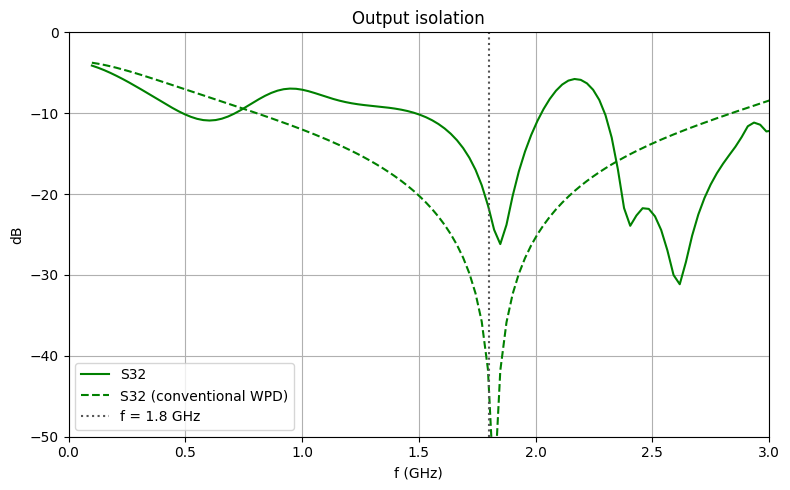

In [31]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S32)), "g", label="S32")
ax.plot(freqs_skrf.f / 1e9, S32dB_skrf, "g--", label="S32 (conventional WPD)")
ax.axline(xy1=(1.8, 0), xy2=(1.8, -50), color="#555555", ls=":", label="f = 1.8 GHz")
ax.legend()
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.set_title("Output isolation")
ax.set_xlim(0, 3)
ax.set_ylim(-50, 0)
ax.grid()
plt.show()

We note that the WPD performance metrics presented in the reference paper are generally better than this simulated device. This is likely due differences in geometry due to omitted dimensions in the paper. The authors also note their use of parametric optimization in order to obtain the most ideal dimensional parameters. 

#### Benchmark Comparison

For benchmarking purposes, we compare the computed S-parameters with results from an independent simulation run on a commercial FEM solver. We find overall very good agreement.

In [32]:
# Import benchmark data
freqs_ben, S11dB_ben, S21dB_ben, S32dB_ben = np.genfromtxt(
    "./misc/wpd-part3-fem.csv", delimiter=",", unpack=True
)

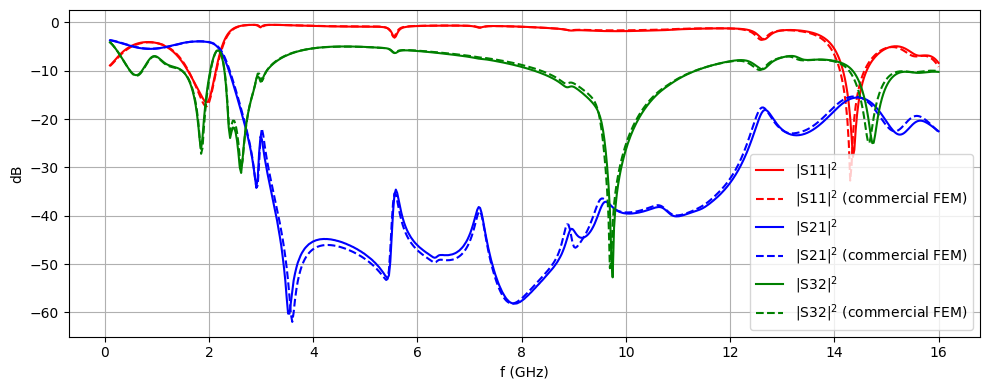

In [33]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S11)), "r", label="|S11|$^2$")
ax.plot(freqs_ben, S11dB_ben, "r--", label="|S11|$^2$ (commercial FEM)")
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S21)), "b", label="|S21|$^2$")
ax.plot(freqs_ben, S21dB_ben, "b--", label="|S21|$^2$ (commercial FEM)")
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S32)), "g", label="|S32|$^2$")
ax.plot(freqs_ben, S32dB_ben, "g--", label="|S32|$^2$ (commercial FEM)")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
ax.grid()
plt.show()

## Conclusion

In this notebook, we simulated the full WPD design presented by Moloudian et al. in [1] and compared its performance to a conventional WPD. The improved WPD features much better signal rejection in the stopband while providing comparable performance at the operating frequency. As noted by the authors, harmonic suppression is a particularly useful feature in modern circuits featuring non-linear elements such as detectors, amplifiers, mixers, and phase shifters. 

* [Designing a power divider for wireless communications part 1: Low-pass resonator](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression1/)
* [Designing a power divider for wireless communications part 2: Adding harmonic suppression](https://www.flexcompute.com/tidy3d/examples/notebooks/WPDHarmonicSuppression2/)

## Reference

[1] Moloudian, G., Soltani, S., Bahrami, S. et al. Design and fabrication of a Wilkinson power divider with harmonic suppression for LTE and GSM applications. Sci Rep 13, 4246 (2023). https://doi.org/10.1038/s41598-023-31019-7